# Word Embeddings
In this notebook, we will implement and train word2vec using the Skip-Gram model and word2vec using the CBOW model in TensorFlow. We will also investigate the behavior of pretrained GloVe embeddings models on an analogy task. This notebook is adapted from https://www.tensorflow.org/tutorials/word2vec.

## Set Up Helpers

In [18]:
%matplotlib inline

import collections
from functools import partial
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange

import tensorflow as tf

# Helper TensorFlow functions
from utils import get_session, maybe_download
from tensorflow.python.ops import candidate_sampling_ops

## Download Data and Parameters

In [19]:
maybe_download('http://mattmahoney.net/dc/text8.zip', 'datasets', 31344016)
maybe_download('http://download.tensorflow.org/data/questions-words.txt', 'datasets', 603955)
maybe_download('http://nlp.stanford.edu/data/glove.6B.zip', 'datasets', 862182613)
if not os.path.exists(os.path.join("datasets", "glove.6B.50d.txt")):
    with zipfile.ZipFile(os.path.join("datasets", "glove.6B.zip"), "r") as zip_ref:
        zip_ref.extractall("datasets")
    for f in ["glove.6B.100d.txt", "glove.6B.300d.txt", "glove.6B.200d.txt"]:
        os.remove(os.path.join('datasets', f))

Found and verified datasets/text8.zip
Found and verified datasets/questions-words.txt
Found and verified datasets/glove.6B.zip


## Setup Up Data

In [20]:
# Read the data into a list of strings.
def read_vocabulary(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_vocabulary(os.path.join('datasets', 'text8.zip'))
print('Number of vocabulary items:', len(vocabulary))

# Build the dictionary and replace rare words with UNK token.
vocab_size = 50000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, 
                                                            vocab_size)
del vocabulary  # To reduce memory consumption
print('Most common words (+UNK):', count[:5])
print('Sample data:', data[:10], [reverse_dictionary[i] for i in data[:10]])

Number of vocabulary items: 17005207
Most common words (+UNK): [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data: [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [21]:
vocabulary = read_vocabulary(os.path.join('datasets', 'text8.zip'))
print(len(collections.Counter(vocabulary)))


253854


In [22]:
del vocabulary

# Why use word embeddings?

A **word embedding** $W: \{1, \dots, N\} \to \mathbb{R}^n$ is a parametric function that maps a word type to a high-dimensional vector. Typically, the function is a simple lookup table parameterized by a matrix $\mathbf{W}$, with a new row for each word type; the query $W(i)$ will return the $i$th row of $\mathbf{W}$. As usual in the machine learning paradigm, $\mathbf{W}$ is initialized randomly, and trained to produce small cost under some objective function.

**What's the motivation for using word embeddings?** We have seen that image processing systems work with complex data encoded as vectors of pixel intensities. On the other hand, traditional NLP systems used to treat words as symbolic tokens. These symbols are arbitrary, and don't provide information about the relationships that may exist between the individual symbols.

To solve these issues, vector space models represent -- or *embed* -- words into a continuous vector space that minimizes distances between semantically similar words.
Predictive vector space models implement this principle by trying to predict a word from its neighbors (or vice versa) in terms of learned embedding vectors that are considered parameters of the model.

In the following, we investigate some different ways of learning word embeddings.

# word2vec with NCE
In classic neural probabilistic  language models (and in tutorial), we use a maximum likelihood criterion to estimate the parameters of a model that computes a vector representation $u_i$ for a word $w_i$ as well as a contextual representation $v_j$ for a history $h_j$ (which could simply be the representation of the preceding word in a unigram model, or a more complex summary of the context). We assume a multinomial distribution over $w_i$, and thus the likelihood objective is a softmax function:

$$\begin{align}
P(w_i | h_j) &= \frac{\exp \{ u_{i} \cdot v_{j} \} }
             {\sum_{k=1}^{|\mathcal{V}|} \exp \{ u_{k} \cdot v_{j} \} }~.
             \tag{1}
\end{align}$$

**But this is very expensive to compute!** At every timestep $t$ and for each word $w_i$, we need to compute the normalization and sum over words in the vocabulary $\mathcal{V}$, which could be extremely large (often around $10^5$ to $10^7$ terms). Luckily, we can use a method called *noise-contrastive estimation* (NCE) so that we needn't use the full probabilistic model as above, but instead use a binary classification objective. The insight is to try to discriminate the target word $w_t$ from randomly sampled *noise* words $\tilde{w} \sim p_\text{noise}(w)$. The noise distribution $p_\text{noise}(w)$ is often chosen to be the uniform distribution over all words in the vocabulary.

NCE can be shown to approximately maximize the log probability of the full softmax in (1); you can check out the original paper that applied NCE to general unnormalized probability models [1] and or its first application to language modeling [2]. In practice, word embedding training procedures use a slightly modified version of the NCE objective, called *negative sampling* (NS), introduced in [3], in which samples from the noise distribution are strictly *negative* examples (i.e., not $w_t$). Consider the NS objective for a single word-context pair:

$$\ell_\text{NS} (w_i, h_j)
= \log p_\theta (D=1 | w_i, h_j) +
  k \mathop{\mathbb{E}}_{\tilde w \sim p_\text{noise}}
  \left[ \log p_\theta(D = 0 |\tilde w, h_j) \right]~.$$

which you can identify as logistic regression applied to the task of distinguishing the target word $w_i$ from draws from the noise distribution $p_\text{noise}(w)$. For a more in-depth explanation, see the tutorial here: https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html#noise-contrastive-estimation-nce.

NS computes a binary classification with sigmoid functions as follows:

$$% <![CDATA[
\begin{align}
p_\theta (D=1 | w_i, h_j) &= \sigma({u_{i}} \cdot v_{j}) \\
p_\theta(D = 0 |w_k, h_j) &= 1 - \sigma({u_{k}} \cdot v_{j}) = \sigma(-{u_{k}}\cdot v_{j})
\end{align} %]]>~.$$

so that the final NS loss function looks like:

$$\mathcal{L}_\theta = - [ \log \sigma({u_i}\cdot v_{j}) +  \sum_{\substack{k=1 \\ w_k \sim p_\text{noise}}}^N \log \sigma(-{u_{k}}\cdot v_{j})]~.\tag{2}$$

**For the word2vec models below, implement the NCE/NS objective (2) instead of the full probabilistic model (1).**

## Q1.A word2vec with CBOW
First off, we'll consider the Continuous Bag-of-Words (CBOW) model of word embeddings (introduced in Section 3.1 in Mikolov et al.). CBOW predicts a target word from its source context words (for example "in the hat" predicts "cat"). Since the source context is treated as a single observation, CBOW tends to neglect specific cooccurences of word types (in contrast to the Skip-Gram model, as we will discuss later).

**For this question, implement the computational graph that computes the NCE objective for the word2vec CBOW model. Do NOT make use of higher-level primitives from the tf.nn module.**

In [23]:
cbow_data_index = 0

def generate_batch_cbow(data, batch_size, context_window=1):
    """Generate a batch of examples and targets for use in the CBOW model."""
    global cbow_data_index
    context_size = 2 * context_window
    batch = np.ndarray(shape=(batch_size, context_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * context_window + 1  # [ context_window target context_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[cbow_data_index])
        cbow_data_index = (cbow_data_index + 1) % len(data)
    for i in range(batch_size):
        # context tokens are just all the tokens in buffer except the target
        batch[i, :] = [token for idx, token in enumerate(buffer) if idx != context_window]
        labels[i, 0] = buffer[context_window]
        buffer.append(data[cbow_data_index])
        cbow_data_index = (cbow_data_index + 1) % len(data)
    return batch, labels

def word2vec_cbow(vocab_size, embed_size, num_noise_samples=64, context_size=2, name='word2vec_cbow'):
    
    with tf.variable_scope(name):
        
        train_inputs = tf.placeholder(tf.int32, shape=[None, context_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        
        ### YOUR CODE HERE
        ### Make sure all variable definitions are within the scope!
        ### Implement the NCE loss as a logistic regression objective
        ### that discriminates noise from data samples
        #raise NotImplementedError("Need to implement the word2vec CBOW objective.")
        
        # generate embeddings matrix
        embeddings = tf.Variable(tf.random_uniform([vocab_size, embed_size], -1.0, 1.0))
        nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embed_size], stddev=1.0/math.sqrt(embed_size)))
        nce_biases = tf.Variable(tf.zeros([vocab_size]))
        
        # embed training inputs and labels
        train_inputs_embedded = tf.gather(embeddings, train_inputs) #Dimension: [batch_size,context_size,embed_size]
        train_labels_embedded = tf.gather(nce_weights, train_labels) #Dimension: [batch_size,1,embed_size]
        train_labels_biases = tf.gather(nce_biases, train_labels) #Dimension: [batch_size, 1]
        train_inputs_embedded_sum = tf.reduce_mean(train_inputs_embedded, 1) #Dimension: [batch_size,embed_size]
        train_inputs_embedded_sum = tf.expand_dims(train_inputs_embedded_sum, 1) #Dimension: [batch_size, 1, embed_size]
        
        # generate and embed noise
        #noise_dataset = tf.random_uniform([batch_size, num_noise_samples],0,vocab_size,tf.int32)
        noise_dataset,_,_ = candidate_sampling_ops.log_uniform_candidate_sampler(tf.cast(train_labels, tf.int64), num_true=1, num_sampled=num_noise_samples, unique=True, range_max=vocab_size)
        noise_dataset = tf.expand_dims(noise_dataset, 0)
        noise_dataset = tf.tile(noise_dataset, [batch_size,1]) #Dimension: [batch_size, num_noise_samples]
        
        #noise_embedded = tf.gather(embeddings, noise_dataset) #Dimension: [batch_size,num_noise_samples,embed_size]
        noise_embedded = tf.gather(nce_weights, noise_dataset) #Dimension: [batch_size,num_noise_samples,embed_size]
        noise_biases = tf.gather(nce_biases, noise_dataset) #Dimension: [batch_size, num_noise_samples]

        # loss1: first term in equation (1)
        loss1 = tf.matmul(train_labels_embedded, train_inputs_embedded_sum, transpose_b=True)
        loss1 = tf.squeeze(loss1) #Dimension: [batch_size]
        loss1 = loss1 + tf.squeeze(train_labels_biases) 
        loss1 = -tf.log_sigmoid(loss1)
        
        # loss2: second term in equation (2)
        loss2 = tf.matmul(train_inputs_embedded_sum, noise_embedded, transpose_b=True) #Dimension: [batch_size,1,num_noise_samples]
        loss2 = tf.squeeze(loss2) #Dimension: [batch_size,num_noise_samples]
        loss2 = loss2 + noise_biases #Dimension: [batch_size,num_noise_samples]
        loss2 = -tf.log_sigmoid(-loss2)
        loss2 = tf.reduce_sum(loss2, 1) #Dimension: [batch_size]
        
        # total loss
        loss_total = loss2 + loss1
        loss = tf.reduce_sum(loss_total)
        loss /= batch_size
        
        ### END YOUR CODE
        ### Your code should instantiate the embeddings and compute the 
        ### loss evaluated on training inputs and labels
        
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.gather(normalized_embeddings, valid_dataset)
        valid_similarity = tf.matmul(valid_embeddings, 
                                     normalized_embeddings, transpose_b=True)

    return train_inputs, train_labels, loss, normalized_embeddings, valid_similarity

## Q1.B word2vec with Skip-Grams
Next up, we'll implement the Skip-Gram model of word embeddings (introduced in Section 3.2 in Mikolov et al.). The approach is algorithmically similar to CBOW; however, since each source context-target pair is treated as a distinct observation, the skip-gram encoding can model more fine-grained information about word cooccurences, and thus is better suited for datasets with infrequent words. However, the model is a little slower to train.

**For this question, implement the computational graph that computes the NCE objective for the word2vec Skip-Gram model. Do NOT make use of higher-level primitives from the tf.nn module.**

In [24]:
skipgram_data_index = 0

def generate_batch_skipgram(data, batch_size, num_skips=2, skip_window=1):
    """Generate a batch of examples and targets for use in the SkipGram model."""
    global skipgram_data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if skipgram_data_index + span > len(data):
        skipgram_data_index = 0
    buffer.extend(data[skipgram_data_index:skipgram_data_index + span])
    skipgram_data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if skipgram_data_index == len(data):
            buffer.extend(data[0:span])
            skipgram_data_index = span
        else:
            buffer.append(data[skipgram_data_index])
            skipgram_data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    skipgram_data_index = (skipgram_data_index + len(data) - span) % len(data)
    return batch, labels

def word2vec_skipgram(vocab_size, embed_size, num_noise_samples=64, name='word2vec_skipgram'):
    
    with tf.variable_scope(name):
        
        train_inputs = tf.placeholder(tf.int32, shape=[None])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        
        ### YOUR CODE HERE
        ### Make sure all variable definitions are within the scope!
        ### Implement the NCE loss as a logistic regression objective
        ### that discriminates noise from data samples
        #raise NotImplementedError("Need to implement the word2vec Skip-Gram objective.")
        
        # generate embeddings matrix
        embeddings = tf.Variable(tf.random_uniform([vocab_size, embed_size], -1.0, 1.0))
        nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embed_size], stddev=1.0/math.sqrt(embed_size)))
        nce_biases = tf.Variable(tf.zeros([vocab_size]))
        
        # embed training inputs and labels
        train_inputs_embedded = tf.gather(embeddings, train_inputs) #Dimension: [batch_size, embed_size]
        train_inputs_embedded = tf.expand_dims(train_inputs_embedded, 1) #Dimension: [batch_size, 1, embed_size]
        train_labels_embedded = tf.gather(nce_weights, train_labels) #Dimension: [batch_size, 1, embed_size]
        train_labels_biases = tf.gather(nce_biases, train_labels) #Dimension: [batch_size, 1]
        
        # generate and embed noise
        #noise_dataset = tf.random_uniform([batch_size, num_noise_samples],0,vocab_size,tf.int32)
        noise_dataset,_,_ = candidate_sampling_ops.log_uniform_candidate_sampler(tf.cast(train_labels, tf.int64), num_true=1, num_sampled=num_noise_samples, unique=True, range_max=vocab_size)
        noise_dataset = tf.expand_dims(noise_dataset, 0)
        noise_dataset = tf.tile(noise_dataset, [batch_size,1])
        
        #noise_embedded = tf.gather(embeddings, noise_dataset) #Dimension: [batch_size,num_noise_samples,embed_size]
        noise_embedded = tf.gather(nce_weights, noise_dataset) #Dimension: [batch_size,num_noise_samples,embed_size]
        noise_biases = tf.gather(nce_biases, noise_dataset) #Dimenson: [batch_size, num_noise_samples]
        
        # loss1: first term in equation (1)
        loss1 = tf.matmul(train_labels_embedded, train_inputs_embedded, transpose_b=True)
        loss1 = tf.squeeze(loss1) #Dimension: [batch_size]
        loss1 = loss1 + tf.squeeze(train_labels_biases)
        loss1 = -tf.log_sigmoid(loss1)
        
        # loss2: second term in equation (2)
        loss2 = tf.matmul(train_inputs_embedded, noise_embedded, transpose_b=True) #Dimension: [batch_size,1,num_noise_samples]
        loss2 = tf.squeeze(loss2) #Dimension: [batch_size,num_noise_samples]
        loss2 = loss2 + noise_biases
        loss2 = -tf.log_sigmoid(-loss2)
        loss2 = tf.reduce_sum(loss2, 1) #Dimension: [batch_size]
        
        # total loss
        loss_total = loss2 + loss1
        loss = tf.reduce_sum(loss_total)
        loss /= batch_size
        
        ### END YOUR CODE
        ### Your code should instantiate the embeddings and compute the 
        ### loss evaluated on training inputs and labels
        
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.gather(normalized_embeddings, valid_dataset)
        valid_similarity = tf.matmul(valid_embeddings, 
                                     normalized_embeddings, transpose_b=True)

    return train_inputs, train_labels, loss, normalized_embeddings, valid_similarity  

## Training
You can test your implementations by checking if the loss decreases over training, looking at the similarity predictions on the validation set, and also visualizing the t-SNE embedded vectors.

In [25]:
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    fig = plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    plt.show()
    return fig

def train_embedding_model(train_inputs, 
                          train_labels, 
                          loss, 
                          normalized_embeddings, 
                          validation_similarities, 
                          generate_batch_fn, 
                          num_steps,
                          lr):

    # Construct the SGD optimizer using a learning rate of 1.0
    # You may find that tuning the learning rate is helpful
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(lr, global_step,10000, 0.96, staircase=True)
    optimize_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)

    # Add variable initializer
    init = tf.global_variables_initializer()

    with get_session() as session:

        init.run()
        print('Initialized the computational graph.')

        average_loss = 0
        for step in xrange(num_steps):

            batch_inputs, batch_labels = generate_batch_fn()
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
                
            # We perform one update step by evaluating the optimizer op (including it
            # in the list of returned values for session.run()
            _, loss_val, lrt = session.run([optimize_op, loss, learning_rate], feed_dict=feed_dict)
            average_loss += loss_val

            if step % 2000 == 0:
                if step > 0:
                    average_loss /= 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step ', step, ': ', average_loss)
                average_loss = 0

            # Note that this is expensive! (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                print('learning rate = ', lrt)
                sim = validation_similarities.eval()
                for i in xrange(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in xrange(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
              
        # Return the values of the embeddings at the end of training
        return normalized_embeddings.eval()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Initialized the computational graph.
Average loss at step  0 :  46.210289001464844
learning rate =  2.0
Nearest to two: spurred, oed, corrective, game, wcl, overthrew, personalities, paraphyletic,
Nearest to so: cricketer, devotions, pigeon, oust, customer, nanometer, depiction, ipo,
Nearest to if: critics, marseilles, wavelengths, cosmopolitan, wereman, congregate, region, veneto,
Nearest to one: mall, foodborne, instrument, surnames, wm, gags, speaker, webcams,
Nearest to three: nat, lascaux, durch, interdisciplinary, suck, necrosis, aho, distinguish,
Nearest to may: multiparty, parmenides, pcd, harkonnen, chalmers, haaretz, tama, meier,
Nearest to many: oslo, reith, repressions, compassion, harpist, evolves, nilpotent, proclamations,
Nearest to new: entailed, bandits, tam, stymied, silicon, olympia, distal, negated,
Nearest to from: kore, bjarne, pandemics, transporting, conditioned, saab, highlander, prized,
N

Average loss at step  52000 :  4.140839634537697
Average loss at step  54000 :  4.113523658394813
Average loss at step  56000 :  4.0912795453071595
Average loss at step  58000 :  4.01599665260315
Average loss at step  60000 :  4.064533678412437
learning rate =  1.5655153
Nearest to two: three, four, five, one, six, eight, seven, isbn,
Nearest to so: customer, andre, cricketer, prohibition, when, away, blocking, calabria,
Nearest to if: when, een, though, before, traveler, accrington, t, above,
Nearest to one: two, four, five, six, seven, three, percent, eight,
Nearest to three: four, five, six, two, seven, eight, nine, one,
Nearest to may: can, would, will, could, must, cannot, should, might,
Nearest to many: some, several, various, these, those, most, other, microkernel,
Nearest to new: large, tam, silicon, historical, vast, chief, great, folk,
Nearest to from: into, during, throughout, through, via, under, in, between,
Nearest to five: four, seven, six, eight, three, nine, zero, two,

Average loss at step  112000 :  3.9323795580863954
Average loss at step  114000 :  3.9520029001235963
Average loss at step  116000 :  3.9738809123039247
Average loss at step  118000 :  3.8274388213157655
Average loss at step  120000 :  3.746305177330971
learning rate =  1.2254192
Nearest to two: three, four, five, six, seven, eight, one, both,
Nearest to so: customer, andre, cricketer, calabria, too, less, aedh, away,
Nearest to if: when, though, before, een, traveler, above, where, since,
Nearest to one: two, libertad, hermann, epoch, particular, jurist, dinner, bone,
Nearest to three: four, five, two, six, seven, eight, nine, distinguish,
Nearest to may: can, would, could, will, must, should, might, cannot,
Nearest to many: some, several, various, most, those, these, few, all,
Nearest to new: tam, large, vast, silicon, chief, racine, folk, museo,
Nearest to from: through, during, throughout, into, via, towards, toward, hypercard,
Nearest to five: four, six, seven, eight, three, nine,

Average loss at step  172000 :  3.8359315552711486
Average loss at step  174000 :  3.81729152405262
Average loss at step  176000 :  3.8051991879940035
Average loss at step  178000 :  3.776312318682671
Average loss at step  180000 :  3.7545739955306052
learning rate =  0.95920634
Nearest to two: three, four, six, five, several, various, both, lm,
Nearest to so: customer, andre, calabria, too, cricketer, aedh, then, thus,
Nearest to if: when, though, before, where, een, traveler, since, above,
Nearest to one: agave, libertad, two, spite, increase, particular, dinner, epoch,
Nearest to three: four, five, two, six, seven, eight, females, several,
Nearest to may: can, would, could, must, should, might, will, cannot,
Nearest to many: several, some, various, most, those, few, certain, these,
Nearest to new: tam, silicon, vast, large, museo, racine, queensland, buckyballs,
Nearest to from: through, during, via, towards, into, toward, throughout, hypercard,
Nearest to five: four, seven, six, ei

Average loss at step  232000 :  3.6702064722776413
Average loss at step  234000 :  3.686589104771614
Average loss at step  236000 :  3.7613816262483595
Average loss at step  238000 :  3.7601884075403214
Average loss at step  240000 :  3.6244838763475418
learning rate =  0.75082606
Nearest to two: three, four, five, six, seven, one, eight, several,
Nearest to so: customer, too, calabria, andre, aedh, thus, cricketer, feed,
Nearest to if: when, though, before, traveler, where, since, een, without,
Nearest to one: two, spite, dar, increase, particular, libertad, resulting, dinner,
Nearest to three: four, five, two, six, seven, eight, nine, several,
Nearest to may: can, would, could, might, should, must, will, cannot,
Nearest to many: several, some, various, most, few, those, numerous, certain,
Nearest to new: vast, tam, museo, silicon, racine, large, queensland, guide,
Nearest to from: through, during, via, throughout, into, toward, across, towards,
Nearest to five: four, six, seven, thre

Average loss at step  292000 :  3.5109109444618225
Average loss at step  294000 :  3.6657889117002487
Average loss at step  296000 :  3.698922636985779
Average loss at step  298000 :  3.654516390800476


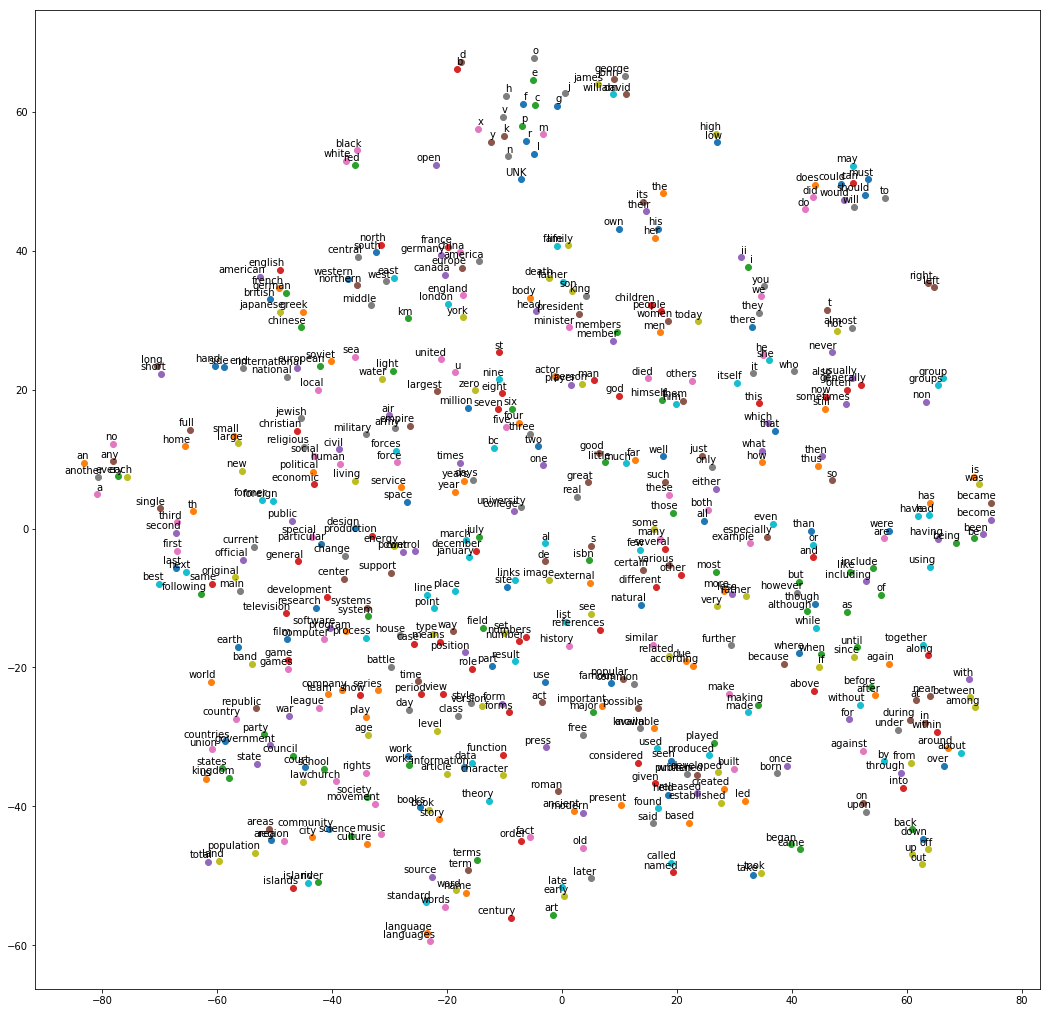

In [26]:
# Use this block to train the different models
embed_size = 128       # embedding dimension
batch_size = 128         # number of examples in a minibatch
num_steps  = 300000 # number of minibatches to observe during training

valid_size = 16      # Random set of words to evaluate similarity on.
valid_window = 100   # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

batch_function_kwargs = {'data': data, 'batch_size': batch_size}

### SELECT MODEL HERE
#train_inputs, train_labels, loss, normalized_embeddings, valid_similarity = word2vec_skipgram(vocab_size, embed_size)
#generate_batch_fn = partial(generate_batch_skipgram, **batch_function_kwargs)

train_inputs, train_labels, loss, normalized_embeddings, valid_similarity = word2vec_cbow(vocab_size, embed_size)
generate_batch_fn = partial(generate_batch_cbow, **batch_function_kwargs)

# Call the training loop
final_embeddings = train_embedding_model(train_inputs, 
                                         train_labels, 
                                         loss, 
                                         normalized_embeddings, 
                                         valid_similarity, 
                                         generate_batch_fn, 
                                         num_steps,
                                         lr=2.0)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    fig_cbow = plot_with_labels(low_dim_embs, labels)
    fig_cbow.savefig('cbow_500.png', bbox_inches='tight')

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

Initialized the computational graph.
Average loss at step  0 :  47.50105285644531
learning rate =  2.0
Nearest to four: gly, shab, draining, macworld, cable, shipyards, superluminal, builds,
Nearest to may: hardness, gpmg, paraphrases, berries, bundestag, xy, vicki, cummins,
Nearest to one: coagulation, nils, betray, malicious, recanted, dickinson, mies, jolie,
Nearest to such: concisely, liga, hydropower, galil, beige, cossacks, frivolous, addison,
Nearest to state: kickboxing, hour, exchangeable, supercomputer, warr, josiah, kinky, canaanite,
Nearest to was: cubes, riverine, newark, lyotropic, trombonist, hypoglycemia, typed, shipbuilding,
Nearest to time: palamas, father, superstition, clarke, recitation, cub, debussy, babylonians,
Nearest to d: universality, germanic, presbyterianism, rawls, armory, menzies, spire, horses,
Nearest to see: hogs, kanagawa, francophone, carving, stumbled, brotherhoods, quebecers, glengarry,
Nearest to over: throwers, military, recognizable, doomsday, 

Average loss at step  52000 :  4.509615330696106
Average loss at step  54000 :  4.567005215644836
Average loss at step  56000 :  4.5484640300273895
Average loss at step  58000 :  4.584790530085564
Average loss at step  60000 :  4.49957126557827
learning rate =  1.5655153
Nearest to four: six, five, eight, three, seven, nine, two, agave,
Nearest to may: can, would, must, could, will, should, cannot, might,
Nearest to one: two, six, four, eight, three, agave, five, seven,
Nearest to such: well, these, many, known, other, described, inconspicuous, freighter,
Nearest to state: city, idea, agave, settlement, dasyprocta, supercomputer, automatic, fela,
Nearest to was: is, had, were, became, has, by, been, be,
Nearest to time: year, day, discovery, pace, person, salicylic, form, extent,
Nearest to d: b, m, c, l, exclusive, repetitions, lithuania, eight,
Nearest to see: but, waldemar, inland, bookshop, inquirer, maryland, controlling, genitive,
Nearest to over: through, about, only, actinium, 

Average loss at step  112000 :  4.48358349943161
Average loss at step  114000 :  4.405165810108185
Average loss at step  116000 :  4.269635530352592
Average loss at step  118000 :  4.409049538493156
Average loss at step  120000 :  4.3804801094532015
learning rate =  1.2254192
Nearest to four: five, seven, six, three, eight, two, nine, zero,
Nearest to may: can, would, could, must, will, should, might, cannot,
Nearest to one: two, six, five, four, agave, seven, three, eight,
Nearest to such: well, these, known, many, including, certain, described, defined,
Nearest to state: city, idea, supercomputer, national, burgundy, anthem, oxford, settlement,
Nearest to was: is, had, became, has, were, been, be, prussians,
Nearest to time: year, day, person, period, extent, years, detected, discovery,
Nearest to d: b, l, m, c, o, z, j, n,
Nearest to see: list, refer, bookshop, ordination, but, can, certificates, waldemar,
Nearest to over: through, about, around, off, across, actinium, encompassing,

Average loss at step  172000 :  4.354417646169662
Average loss at step  174000 :  4.326013620138168
Average loss at step  176000 :  4.382277294278145
Average loss at step  178000 :  4.355140148639679
Average loss at step  180000 :  4.385969989061356
learning rate =  0.95920634
Nearest to four: five, six, seven, eight, three, two, nine, zero,
Nearest to may: can, would, could, must, should, will, might, cannot,
Nearest to one: two, seven, six, four, three, eight, agave, five,
Nearest to such: these, known, well, many, certain, including, those, few,
Nearest to state: city, federal, national, burgundy, government, states, republic, anthem,
Nearest to was: is, became, had, has, were, be, been, although,
Nearest to time: period, year, day, person, extent, discovery, detected, napoleonic,
Nearest to d: b, l, m, c, o, v, n, z,
Nearest to see: list, but, refer, bookshop, waldemar, refers, history, represent,
Nearest to over: through, about, around, off, across, beyond, actinium, beatification

Average loss at step  232000 :  4.3364543764591215
Average loss at step  234000 :  4.322379628896713
Average loss at step  236000 :  4.4080159804821015
Average loss at step  238000 :  4.293653549611569
Average loss at step  240000 :  4.3763063679933545
learning rate =  0.75082606
Nearest to four: five, three, six, seven, eight, two, nine, zero,
Nearest to may: can, must, could, would, will, should, might, cannot,
Nearest to one: two, seven, five, three, four, six, eight, agave,
Nearest to such: these, well, known, many, certain, including, staunch, those,
Nearest to state: city, national, federal, burgundy, government, provincial, republic, anthem,
Nearest to was: is, had, became, were, has, be, been, although,
Nearest to time: period, year, day, extent, person, napoleonic, decades, statement,
Nearest to d: b, l, di, c, n, m, o, z,
Nearest to see: list, but, refers, refer, bookshop, waldemar, include, references,
Nearest to over: through, around, beyond, about, across, off, actinium, e

Average loss at step  292000 :  4.237000386476517
Average loss at step  294000 :  4.286157333016396
Average loss at step  296000 :  4.250706366181373
Average loss at step  298000 :  4.289876574873924
Average loss at step  300000 :  4.255174873113632
learning rate =  0.58771485
Nearest to four: five, six, three, seven, eight, two, nine, zero,
Nearest to may: can, must, could, should, might, would, will, cannot,
Nearest to one: two, three, seven, four, agave, six, five, fact,
Nearest to such: these, well, known, including, certain, many, defined, regarded,
Nearest to state: city, national, federal, burgundy, government, states, provincial, republic,
Nearest to was: is, became, were, had, has, be, although, been,
Nearest to time: period, year, day, extent, person, injuring, napoleonic, money,
Nearest to d: b, l, french, conseil, di, glissando, z, sprawling,
Nearest to see: list, but, refers, refer, waldemar, include, references, includes,
Nearest to over: through, around, about, beyond, o

Average loss at step  352000 :  4.3040524344444275
Average loss at step  354000 :  4.28689157140255
Average loss at step  356000 :  4.283267209291458
Average loss at step  358000 :  4.259462797403335
Average loss at step  360000 :  4.283338615894317
learning rate =  0.46003833
Nearest to four: five, six, seven, three, eight, two, nine, zero,
Nearest to may: can, must, could, should, might, would, will, cannot,
Nearest to one: two, seven, four, six, five, three, eight, fact,
Nearest to such: these, well, known, certain, many, including, defined, regarded,
Nearest to state: city, national, federal, states, burgundy, government, provincial, anthem,
Nearest to was: is, became, were, had, has, be, been, although,
Nearest to time: period, year, extent, day, attributing, money, napoleonic, fripp,
Nearest to d: b, l, di, z, c, j, phi, o,
Nearest to see: list, but, refers, refer, waldemar, references, include, certificates,
Nearest to over: around, through, about, beyond, across, off, within, m

Average loss at step  412000 :  4.2679967746734615
Average loss at step  414000 :  4.226959248423577
Average loss at step  416000 :  4.168324891090393
Average loss at step  418000 :  4.168794609904289
Average loss at step  420000 :  4.246458922863007
learning rate =  0.36009857
Nearest to four: five, six, three, seven, eight, two, nine, zero,
Nearest to may: can, must, should, could, might, would, will, cannot,
Nearest to one: two, six, three, five, seven, four, digit, agave,
Nearest to such: these, known, well, certain, many, including, few, defined,
Nearest to state: city, national, federal, burgundy, states, provincial, government, anthem,
Nearest to was: is, became, had, were, has, be, been, although,
Nearest to time: period, extent, year, day, money, attributing, napoleonic, injuring,
Nearest to d: b, l, di, z, mol, c, repetitions, phi,
Nearest to see: list, but, refers, references, refer, includes, waldemar, include,
Nearest to over: through, around, beyond, about, across, off, w

Average loss at step  472000 :  4.116314679741859
Average loss at step  474000 :  4.1747372280359265
Average loss at step  476000 :  4.2017351167202
Average loss at step  478000 :  4.241078436017037
Average loss at step  480000 :  4.160975897312165
learning rate =  0.28186992
Nearest to four: five, six, seven, three, eight, two, nine, zero,
Nearest to may: can, must, should, could, might, would, will, cannot,
Nearest to one: two, seven, three, agave, four, december, addition, january,
Nearest to such: these, well, known, certain, many, including, those, few,
Nearest to state: city, national, federal, burgundy, states, provincial, government, republic,
Nearest to was: is, became, had, were, has, be, been, although,
Nearest to time: period, year, extent, day, attributing, napoleonic, decades, fripp,
Nearest to d: b, l, di, glissando, mol, conseil, repetitions, french,
Nearest to see: list, but, refers, refer, references, waldemar, includes, include,
Nearest to over: around, through, beyo

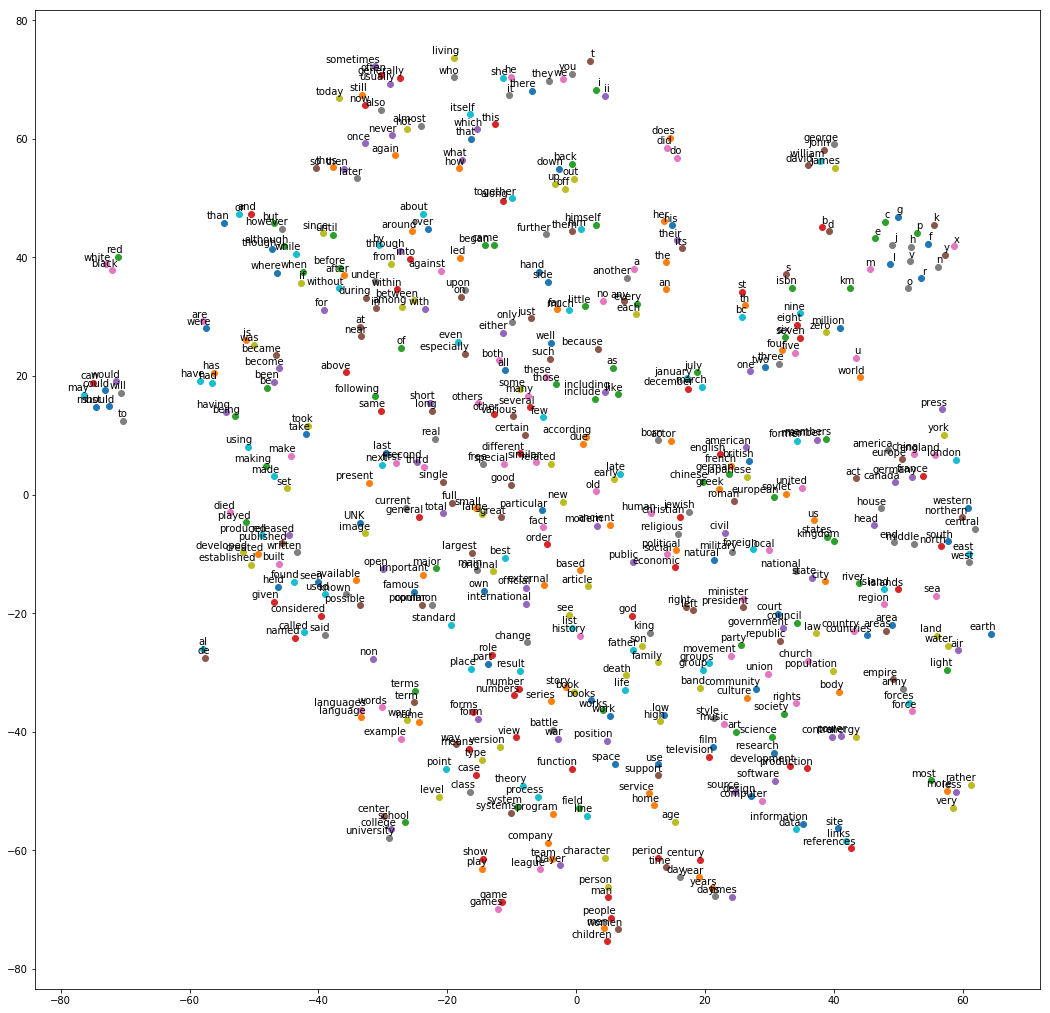

In [27]:
# Use this block to train the different models
embed_size = 128       # embedding dimension
batch_size = 128         # number of examples in a minibatch
num_steps  = 500000 # number of minibatches to observe during training

valid_size = 16      # Random set of words to evaluate similarity on.
valid_window = 100   # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

batch_function_kwargs = {'data': data, 'batch_size': batch_size}

### SELECT MODEL HERE
train_inputs, train_labels, loss, normalized_embeddings, valid_similarity = word2vec_skipgram(vocab_size, embed_size)
generate_batch_fn = partial(generate_batch_skipgram, **batch_function_kwargs)

#train_inputs, train_labels, loss, normalized_embeddings, valid_similarity = word2vec_cbow(vocab_size, embed_size)
#generate_batch_fn = partial(generate_batch_cbow, **batch_function_kwargs)

# Call the training loop
final_embeddings = train_embedding_model(train_inputs, 
                                         train_labels, 
                                         loss, 
                                         normalized_embeddings, 
                                         valid_similarity, 
                                         generate_batch_fn, 
                                         num_steps,
                                         lr=2.0)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    fig_skip = plot_with_labels(low_dim_embs, labels)
    fig_skip.savefig('skipgram_500.png', bbox_inches='tight')

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)